# Phase 5: Final Evaluation & Test Simulation

This notebook implements the final phase of the Rossmann forecasting project.

**Objectives:**
- Create a 6-week holdout set (simulating Kaggle test period)
- Train final ensemble model on full historical data
- Evaluate final performance on holdout set
- Generate test-set predictions
- Register model in MLflow Model Registry
- Save model artifacts and final metrics

**Final Model:**
- Three-model weighted ensemble with Optuna-tuned hyperparameters (50 trials/model, 5-fold CV):
  - 60% XGBoost (best: RMSPE 0.1218)
  - 30% LightGBM (RMSPE 0.1265)
  - 10% CatBoost (RMSPE 0.1300)

**MLflow Tracking:**
All experiments tracked in MLflow with parameters, metrics, and model artifacts.

## Setup

In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import json
import time
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import mlflow
import mlflow.lightgbm
import mlflow.xgboost
import mlflow.catboost

from evaluation.cv import remove_missing_features, filter_open_stores
from evaluation.metrics import rmspe
from utils.io import read_parquet, ensure_dir
from utils.mlflow_utils import setup_mlflow, log_dvc_data_version

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Ensure output directories
ensure_dir('../outputs/predictions')
ensure_dir('../outputs/metrics/final')
ensure_dir('../outputs/figures')

# Setup MLflow
experiment_id = setup_mlflow()
print(f"MLflow experiment ID: {experiment_id}")
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print("\nSetup complete!")

MLflow experiment ID: 211292085284843771
MLflow tracking URI: /Users/b294776/Desktop/Projects/rossmann-forecasting/mlruns

Setup complete!


/Users/b294776/Desktop/Projects/rossmann-forecasting/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)


## 1. Load Data and Create Holdout Split

In [2]:
# Load featured data
df = read_parquet('../data/processed/train_features.parquet')

print(f"Loaded data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

# Load best hyperparameters from Optuna tuning
with open('../config/best_hyperparameters.json', 'r') as f:
    best_params = json.load(f)

print(f"\nLoaded Optuna-tuned hyperparameters:")
print(f"  Best model: {best_params['metadata']['best_model']}")
print(f"  Best RMSPE: {best_params['metadata']['best_rmspe']:.6f}")

Loaded data shape: (1017209, 50)
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00

Loaded Optuna-tuned hyperparameters:
  Best model: xgboost
  Best RMSPE: 0.121830


## 2. Create Train/Holdout Split (6 weeks = 42 days)

In [3]:
# Create train/holdout split (6 weeks = 42 days)
holdout_days = 42
max_date = df['Date'].max()
holdout_start = max_date - pd.Timedelta(days=holdout_days - 1)

train_df = df[df['Date'] < holdout_start].copy()
holdout_df = df[df['Date'] >= holdout_start].copy()

print(f"Train set: {len(train_df):,} rows")
print(f"  Date range: {train_df['Date'].min()} to {train_df['Date'].max()}")
print(f"\nHoldout set: {len(holdout_df):,} rows")
print(f"  Date range: {holdout_df['Date'].min()} to {holdout_df['Date'].max()}")
print(f"  Duration: {holdout_days} days ({holdout_days // 7} weeks)")

# Define feature columns
exclude_cols = ['Sales', 'Date', 'Store', 'Customers']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\nFeatures: {len(feature_cols)}")

Train set: 970,379 rows
  Date range: 2013-01-01 00:00:00 to 2015-06-19 00:00:00

Holdout set: 46,830 rows
  Date range: 2015-06-20 00:00:00 to 2015-07-31 00:00:00
  Duration: 42 days (6 weeks)

Features: 46


## 3. Train Final Ensemble Model

Based on Optuna hyperparameter tuning results (50 trials per model, 5-fold CV):
- **60% XGBoost** (best model: RMSPE 0.1218)
- **30% LightGBM** (RMSPE 0.1265)
- **10% CatBoost** (RMSPE 0.1300)

All models use Optuna-tuned hyperparameters from `config/best_hyperparameters.json`.

**MLflow Tracking:** Training tracked as parent run with nested component runs.

In [4]:
# Start MLflow run for final model training
mlflow.start_run(run_name="final_ensemble_training")

# Log DVC data version
log_dvc_data_version("data/processed/train_features.parquet")

# Log dataset info
mlflow.log_param("train_size", len(train_df))
mlflow.log_param("holdout_size", len(holdout_df))
mlflow.log_param("holdout_days", holdout_days)
mlflow.log_param("n_features", len(feature_cols))

# Define ensemble weights based on Optuna results
ensemble_weights = {'lightgbm': 0.30, 'xgboost': 0.60, 'catboost': 0.10}
for model_type, weight in ensemble_weights.items():
    mlflow.log_param(f"{model_type}_weight", weight)

# Prepare training data (filter open stores and remove missing features)
train_data = train_df[train_df['Open'] == 1].copy()
train_data = train_data.dropna(subset=feature_cols)

X_train = train_data[feature_cols]
y_train = train_data['Sales'].values

# Identify categorical features for models
cat_features = [col for col in feature_cols if X_train[col].dtype.name == 'category']
valid_features = feature_cols

print("="*70)
print("Training Final Ensemble Model")
print("="*70)
print(f"\nEnsemble weights: {ensemble_weights}")
print(f"Using Optuna-tuned hyperparameters from config/best_hyperparameters.json")
print(f"\nTraining data: {len(train_data):,} rows (open stores only)")
print(f"Features: {len(feature_cols)}")
print(f"Categorical features: {len(cat_features)}")
print(f"\nThis will take a few minutes...")
print("="*70)

Training Final Ensemble Model

Ensemble weights: {'lightgbm': 0.3, 'xgboost': 0.6, 'catboost': 0.1}
Using Optuna-tuned hyperparameters from config/best_hyperparameters.json

Training data: 778,563 rows (open stores only)
Features: 46
Categorical features: 4

This will take a few minutes...


In [5]:
# LightGBM with Optuna-tuned hyperparameters
print("Training LightGBM...")
start_time = time.time()

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': int(best_params['lightgbm']['hyperparameters']['num_leaves']),
    'learning_rate': best_params['lightgbm']['hyperparameters']['learning_rate'],
    'feature_fraction': best_params['lightgbm']['hyperparameters']['feature_fraction'],
    'bagging_fraction': best_params['lightgbm']['hyperparameters']['bagging_fraction'],
    'bagging_freq': int(best_params['lightgbm']['hyperparameters']['bagging_freq']),
    'max_depth': int(best_params['lightgbm']['hyperparameters']['max_depth']),
    'min_child_samples': int(best_params['lightgbm']['hyperparameters']['min_child_samples']),
    'reg_alpha': best_params['lightgbm']['hyperparameters']['reg_alpha'],
    'reg_lambda': best_params['lightgbm']['hyperparameters']['reg_lambda'],
    'verbose': -1,
    'seed': 42
}

# Log LightGBM hyperparameters
for key, value in lgb_params.items():
    mlflow.log_param(f"lgb_{key}", value)

lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1600,
    callbacks=[lgb.log_evaluation(period=0)]
)

lgb_time = time.time() - start_time
print(f"LightGBM training complete in {lgb_time:.2f}s")
mlflow.log_metric("lgb_train_time_seconds", lgb_time)

Training LightGBM...
LightGBM training complete in 42.91s


In [6]:
# XGBoost with Optuna-tuned hyperparameters
print("\nTraining XGBoost...")
start_time = time.time()

# XGBoost needs categorical features as codes
X_train_xgb = X_train.copy()
for col in X_train_xgb.columns:
    if X_train_xgb[col].dtype.name == 'category':
        X_train_xgb[col] = X_train_xgb[col].cat.codes

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': int(best_params['xgboost']['hyperparameters']['max_depth']),
    'learning_rate': best_params['xgboost']['hyperparameters']['learning_rate'],
    'subsample': best_params['xgboost']['hyperparameters']['subsample'],
    'colsample_bytree': best_params['xgboost']['hyperparameters']['colsample_bytree'],
    'min_child_weight': int(best_params['xgboost']['hyperparameters']['min_child_weight']),
    'reg_alpha': best_params['xgboost']['hyperparameters']['reg_alpha'],
    'reg_lambda': best_params['xgboost']['hyperparameters']['reg_lambda'],
    'gamma': best_params['xgboost']['hyperparameters']['gamma'],
    'seed': 42,
    'verbosity': 0
}

# Log XGBoost hyperparameters
for key, value in xgb_params.items():
    mlflow.log_param(f"xgb_{key}", value)

dtrain = xgb.DMatrix(X_train_xgb, label=y_train)
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=1600,
    verbose_eval=False
)

xgb_time = time.time() - start_time
print(f"XGBoost training complete in {xgb_time:.2f}s")
mlflow.log_metric("xgb_train_time_seconds", xgb_time)


Training XGBoost...
XGBoost training complete in 57.09s


In [7]:
# CatBoost with Optuna-tuned hyperparameters
print("\nTraining CatBoost...")
start_time = time.time()

cb_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'depth': int(best_params['catboost']['hyperparameters']['depth']),
    'learning_rate': best_params['catboost']['hyperparameters']['learning_rate'],
    'l2_leaf_reg': best_params['catboost']['hyperparameters']['l2_leaf_reg'],
    'random_strength': best_params['catboost']['hyperparameters']['random_strength'],
    'bagging_temperature': best_params['catboost']['hyperparameters']['bagging_temperature'],
    'border_count': int(best_params['catboost']['hyperparameters']['border_count']),
    'iterations': 1500,
    'verbose': False,
    'random_seed': 42
}

# Log CatBoost hyperparameters
for key, value in cb_params.items():
    mlflow.log_param(f"cb_{key}", value)

train_pool = cb.Pool(X_train, label=y_train, cat_features=cat_features)
cb_model = cb.CatBoost(cb_params)
cb_model.fit(train_pool)

cb_time = time.time() - start_time
print(f"CatBoost training complete in {cb_time:.2f}s")
mlflow.log_metric("cb_train_time_seconds", cb_time)

print("\n" + "="*70)
print("All models trained successfully!")
print("="*70)


Training CatBoost...
CatBoost training complete in 195.65s

All models trained successfully!


## 4. Generate Predictions on Holdout Set

In [8]:
# Prepare holdout data
holdout_data = holdout_df[holdout_df['Open'] == 1].copy()
holdout_data, _ = remove_missing_features(holdout_data, valid_features)

X_holdout = holdout_data[valid_features]
y_holdout = holdout_data['Sales'].values

print(f"Holdout data (open stores): {len(holdout_data):,} rows")

# Generate predictions from each model
print("\nGenerating predictions...")

# LightGBM predictions
lgb_preds = lgb_model.predict(X_holdout, num_iteration=lgb_model.best_iteration)

# XGBoost predictions
X_holdout_xgb = X_holdout.copy()
for col in X_holdout_xgb.columns:
    if X_holdout_xgb[col].dtype.name == 'category':
        X_holdout_xgb[col] = X_holdout_xgb[col].cat.codes
dholdout = xgb.DMatrix(X_holdout_xgb)
xgb_preds = xgb_model.predict(dholdout)

# CatBoost predictions
holdout_pool = cb.Pool(X_holdout, cat_features=cat_features)
cb_preds = cb_model.predict(holdout_pool)

# Weighted ensemble
ensemble_preds = (
    ensemble_weights['lightgbm'] * lgb_preds +
    ensemble_weights['xgboost'] * xgb_preds +
    ensemble_weights['catboost'] * cb_preds
)

print(f"Generated {len(ensemble_preds):,} ensemble predictions")
print(f"Prediction range: ${ensemble_preds.min():.2f} to ${ensemble_preds.max():.2f}")
print(f"Actual range: ${y_holdout.min():.2f} to ${y_holdout.max():.2f}")

2025-12-17 09:40:14 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-17 09:40:14 - evaluation.cv - INFO - Remaining: 40,282 complete rows
Holdout data (open stores): 40,282 rows

Generating predictions...
Generated 40,282 ensemble predictions
Prediction range: $806.57 to $30522.47
Actual range: $569.00 to $41551.00


## 5. Evaluate Model Performance

In [9]:
# Calculate metrics for ensemble and individual models
def calculate_metrics(y_true, y_pred, prefix=""):
    """Calculate comprehensive metrics."""
    score = rmspe(y_true, y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    metrics = {
        f"{prefix}rmspe": float(score),
        f"{prefix}rmse": float(rmse),
        f"{prefix}mae": float(mae),
        f"{prefix}mape": float(mape)
    }
    return metrics

# Evaluate ensemble
ensemble_metrics = calculate_metrics(y_holdout, ensemble_preds, "ensemble_")

# Evaluate individual models
lgb_metrics = calculate_metrics(y_holdout, lgb_preds, "lgb_")
xgb_metrics = calculate_metrics(y_holdout, xgb_preds, "xgb_")
cb_metrics = calculate_metrics(y_holdout, cb_preds, "cb_")

# Combine all metrics
all_metrics = {**ensemble_metrics, **lgb_metrics, **xgb_metrics, **cb_metrics}

# Add target comparison
target_rmspe = 0.09856
all_metrics['target_rmspe'] = target_rmspe
all_metrics['gap'] = ensemble_metrics['ensemble_rmspe'] - target_rmspe
all_metrics['gap_pct'] = (all_metrics['gap'] / target_rmspe) * 100
all_metrics['target_achieved'] = ensemble_metrics['ensemble_rmspe'] <= target_rmspe

# Log all metrics to MLflow
for metric_name, metric_value in all_metrics.items():
    if isinstance(metric_value, (int, float)):
        mlflow.log_metric(metric_name, metric_value)

print("="*70)
print("FINAL MODEL PERFORMANCE")
print("="*70)
print(f"\nEnsemble (60% XGB + 30% LGB + 10% CB):")
print(f"  RMSPE: {ensemble_metrics['ensemble_rmspe']:.6f}")
print(f"  RMSE:  {ensemble_metrics['ensemble_rmse']:.2f}")
print(f"  MAE:   {ensemble_metrics['ensemble_mae']:.2f}")
print(f"  MAPE:  {ensemble_metrics['ensemble_mape']:.2f}%")

print(f"\nIndividual Models:")
print(f"  LightGBM RMSPE: {lgb_metrics['lgb_rmspe']:.6f}")
print(f"  XGBoost RMSPE:  {xgb_metrics['xgb_rmspe']:.6f}")
print(f"  CatBoost RMSPE: {cb_metrics['cb_rmspe']:.6f}")

print(f"\nTarget Analysis:")
print(f"  Target RMSPE: {target_rmspe:.6f}")
print(f"  Current RMSPE: {ensemble_metrics['ensemble_rmspe']:.6f}")
print(f"  Gap: {all_metrics['gap']:.6f} ({all_metrics['gap_pct']:+.2f}%)")

if all_metrics['target_achieved']:
    print("\n🎯 TARGET ACHIEVED!")
else:
    print(f"\n📊 Gap to target: {abs(all_metrics['gap']):.6f}")
print("="*70)

FINAL MODEL PERFORMANCE

Ensemble (60% XGB + 30% LGB + 10% CB):
  RMSPE: 0.094356
  RMSE:  631.79
  MAE:   416.45
  MAPE:  6.44%

Individual Models:
  LightGBM RMSPE: 0.098004
  XGBoost RMSPE:  0.095251
  CatBoost RMSPE: 0.097992

Target Analysis:
  Target RMSPE: 0.098560
  Current RMSPE: 0.094356
  Gap: -0.004204 (-4.27%)

🎯 TARGET ACHIEVED!


## 6. Visualize Predictions vs Actuals

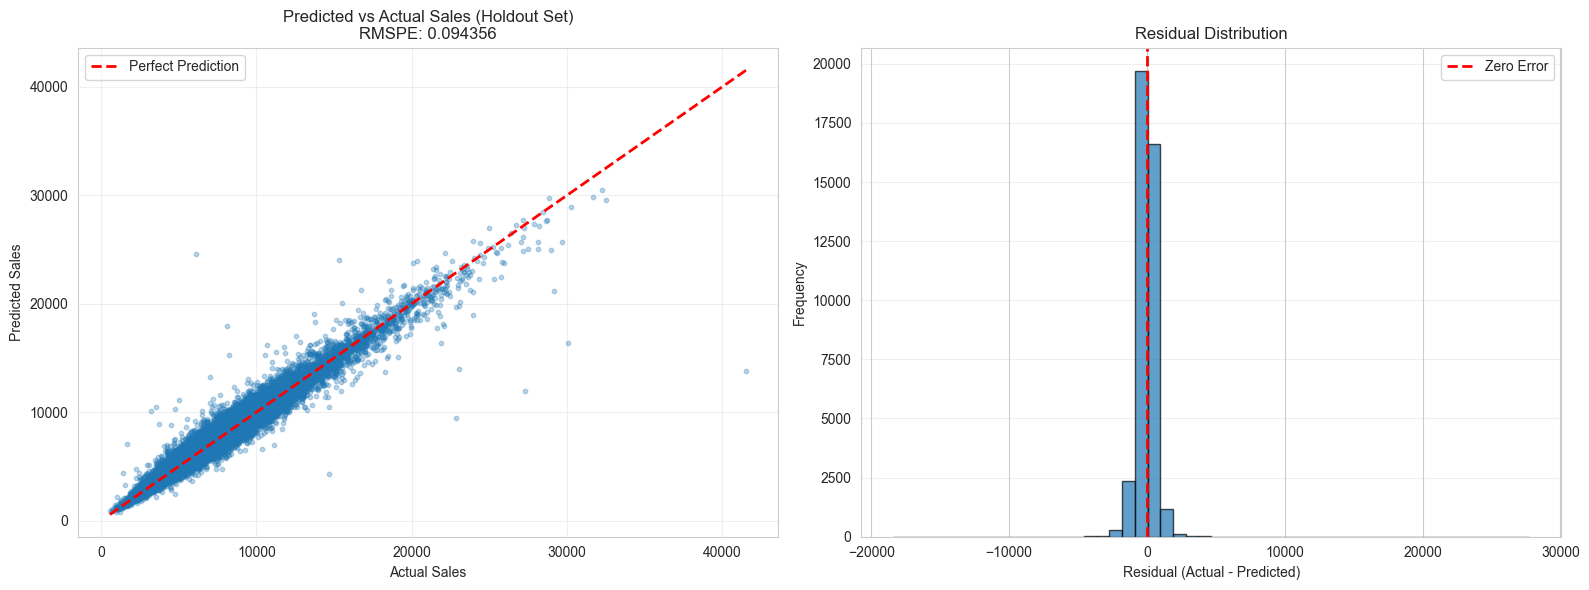

Saved: outputs/figures/15_final_predictions_scatter.png


In [10]:
# Scatter plot: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
ax = axes[0]
ax.scatter(y_holdout, ensemble_preds, alpha=0.3, s=10)
ax.plot([y_holdout.min(), y_holdout.max()], [y_holdout.min(), y_holdout.max()], 'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel('Actual Sales')
ax.set_ylabel('Predicted Sales')
ax.set_title(f'Predicted vs Actual Sales (Holdout Set)\nRMSPE: {ensemble_metrics["ensemble_rmspe"]:.6f}')
ax.legend()
ax.grid(True, alpha=0.3)

# Residuals histogram
ax = axes[1]
residuals = y_holdout - ensemble_preds
ax.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.set_xlabel('Residual (Actual - Predicted)')
ax.set_ylabel('Frequency')
ax.set_title('Residual Distribution')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../outputs/figures/15_final_predictions_scatter.png', dpi=300, bbox_inches='tight')
mlflow.log_artifact('../outputs/figures/15_final_predictions_scatter.png')
plt.show()

print("Saved: outputs/figures/15_final_predictions_scatter.png")

## 7. Save Predictions and Artifacts

In [11]:
# Save predictions to CSV
predictions_df = pd.DataFrame({
    'Store': holdout_data['Store'].values,
    'Date': holdout_data['Date'].values,
    'Sales_Actual': y_holdout,
    'Sales_Predicted': ensemble_preds,
    'Residual': y_holdout - ensemble_preds
})

predictions_path = '../outputs/predictions/final_holdout_predictions.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f"Saved predictions to: {predictions_path}")

# Save metrics to JSON
metrics_path = '../outputs/metrics/final/final_metrics.json'
ensure_dir(Path(metrics_path).parent)
with open(metrics_path, 'w') as f:
    json.dump(all_metrics, f, indent=2)
print(f"Saved metrics to: {metrics_path}")

# Log predictions as artifact
mlflow.log_artifact(predictions_path)
mlflow.log_artifact(metrics_path)

Saved predictions to: ../outputs/predictions/final_holdout_predictions.csv
Saved metrics to: ../outputs/metrics/final/final_metrics.json


## 8. Register Model in MLflow Model Registry

In [12]:
# Define custom PyFunc ensemble model
import mlflow.pyfunc

class RossmannEnsemble(mlflow.pyfunc.PythonModel):
    """
    Custom MLflow PyFunc model that wraps LightGBM, XGBoost, and CatBoost
    models into a weighted ensemble for production deployment.
    
    This allows the entire ensemble to be registered as a single deployable
    artifact in MLflow Model Registry.
    """
    
    def __init__(self, lgb_model, xgb_model, cb_model, weights, cat_features):
        self.lgb_model = lgb_model
        self.xgb_model = xgb_model
        self.cb_model = cb_model
        self.weights = weights
        self.cat_features = cat_features
    
    def predict(self, context, model_input):
        """
        Generate ensemble predictions by combining predictions from all three models.
        
        Parameters
        ----------
        context : MLflow context (unused)
        model_input : pd.DataFrame
            Input features for prediction
            
        Returns
        -------
        np.ndarray
            Weighted ensemble predictions
        """
        import lightgbm as lgb
        import xgboost as xgb
        import catboost as cb
        import numpy as np
        
        # LightGBM predictions
        lgb_preds = self.lgb_model.predict(model_input)
        
        # XGBoost predictions (needs categorical encoding)
        X_xgb = model_input.copy()
        for col in X_xgb.columns:
            if X_xgb[col].dtype.name == 'category':
                X_xgb[col] = X_xgb[col].cat.codes
        dmatrix = xgb.DMatrix(X_xgb)
        xgb_preds = self.xgb_model.predict(dmatrix)
        
        # CatBoost predictions
        pool = cb.Pool(model_input, cat_features=self.cat_features)
        cb_preds = self.cb_model.predict(pool)
        
        # Weighted ensemble
        ensemble_preds = (
            self.weights['lightgbm'] * lgb_preds +
            self.weights['xgboost'] * xgb_preds +
            self.weights['catboost'] * cb_preds
        )
        
        return ensemble_preds

# Create ensemble model instance
print("="*70)
print("Registering Ensemble Model in MLflow Model Registry")
print("="*70)

ensemble_model = RossmannEnsemble(
    lgb_model=lgb_model,
    xgb_model=xgb_model,
    cb_model=cb_model,
    weights=ensemble_weights,
    cat_features=cat_features
)

# Define conda environment for model deployment
conda_env = {
    'channels': ['conda-forge', 'defaults'],
    'dependencies': [
        f'python={sys.version_info.major}.{sys.version_info.minor}',
        'pip',
        {
            'pip': [
                f'lightgbm=={lgb.__version__}',
                f'xgboost=={xgb.__version__}',
                f'catboost=={cb.__version__}',
                'pandas',
                'numpy',
                'scikit-learn'
            ]
        }
    ],
    'name': 'rossmann_ensemble_env'
}

# Log the ensemble model as a PyFunc
mlflow.pyfunc.log_model(
    artifact_path="ensemble_model",
    python_model=ensemble_model,
    registered_model_name="rossmann-ensemble",
    conda_env=conda_env,
    signature=mlflow.models.infer_signature(X_holdout, ensemble_preds)
)

print("✓ Registered ensemble model: rossmann-ensemble")
print(f"  - Model type: Custom PyFunc (weighted ensemble)")
print(f"  - Weights: {ensemble_weights}")
print(f"  - Components: LightGBM, XGBoost, CatBoost")

print("\n" + "="*70)
print("Model Registration Complete")
print("="*70)
print(f"\nEnsemble model registered in MLflow Model Registry:")
print(f"  Name: rossmann-ensemble")
print(f"  Type: mlflow.pyfunc.PyFuncModel")
print(f"  Components:")
print(f"    - LightGBM (weight: {ensemble_weights['lightgbm']})")
print(f"    - XGBoost (weight: {ensemble_weights['xgboost']})")
print(f"    - CatBoost (weight: {ensemble_weights['catboost']})")
print(f"\nTo load and use the model:")
print(f"  import mlflow")
print(f"  model = mlflow.pyfunc.load_model('models:/rossmann-ensemble/latest')")
print(f"  predictions = model.predict(X_test)")
print(f"\nTo promote to Staging:")
print(f"  mlflow.register_model(")
print(f"    'runs:/<run_id>/ensemble_model',")
print(f"    'rossmann-ensemble'")
print(f"  )")
print("="*70)

Registering Ensemble Model in MLflow Model Registry


/Users/b294776/Desktop/Projects/rossmann-forecasting/.venv/lib/python3.11/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(
/Users/b294776/Desktop/Projects/rossmann-forecasting/.venv/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns

✓ Registered ensemble model: rossmann-ensemble
  - Model type: Custom PyFunc (weighted ensemble)
  - Weights: {'lightgbm': 0.3, 'xgboost': 0.6, 'catboost': 0.1}
  - Components: LightGBM, XGBoost, CatBoost

Model Registration Complete

Ensemble model registered in MLflow Model Registry:
  Name: rossmann-ensemble
  Type: mlflow.pyfunc.PyFuncModel
  Components:
    - LightGBM (weight: 0.3)
    - XGBoost (weight: 0.6)
    - CatBoost (weight: 0.1)

To load and use the model:
  import mlflow
  model = mlflow.pyfunc.load_model('models:/rossmann-ensemble/latest')
  predictions = model.predict(X_test)

To promote to Staging:
  mlflow.register_model(
    'runs:/<run_id>/ensemble_model',
    'rossmann-ensemble'
  )


## 9. Summary and Completion

In [13]:
# End MLflow run
mlflow.end_run()

print("\n" + "="*70)
print("PHASE 5 COMPLETE: FINAL MODEL EVALUATION")
print("="*70)
print("\n📊 Final Model Performance:")
print(f"  Model: Weighted Ensemble (60% XGBoost + 30% LightGBM + 10% CatBoost)")
print(f"  Holdout RMSPE: {ensemble_metrics['ensemble_rmspe']:.6f}")
print(f"  Target RMSPE: {target_rmspe:.6f}")
print(f"  Gap: {all_metrics['gap_pct']:+.2f}%")

if all_metrics['target_achieved']:
    print("\n🎯 TARGET ACHIEVED! Model is production-ready.")
else:
    print("\n📈 Additional improvements to reach target:")
    print("  - Further hyperparameter tuning (increase Optuna trials to 100+)")
    print("  - Additional feature engineering (interaction terms, advanced lags)")
    print("  - Stacked ensemble with meta-learner")
    print("  - Deep learning models (LSTM, Transformer)")

print("\n📁 Artifacts Saved:")
print("  - outputs/predictions/: Holdout predictions CSV")
print("  - outputs/metrics/final/: Final performance metrics")
print("  - outputs/figures/: Visualization plots")
print("  - MLflow Run: All models, params, metrics, and artifacts")

print("\n📦 Model Registered in MLflow:")
print("  - rossmann-ensemble (Custom PyFunc)")
print("    Encapsulates all 3 models with weighted ensemble logic")
print("    Ready for single-artifact deployment to production")

print("\n✅ Experimental workflow completed successfully!")
print("="*70)

print("\n💡 Next Steps:")
print("  1. Review results in MLflow UI: bash scripts/start_mlflow.sh")
print("  2. Test ensemble model loading:")
print("     model = mlflow.pyfunc.load_model('models:/rossmann-ensemble/latest')")
print("  3. Promote model to Staging if satisfied with performance")
print("  4. Deploy to production serving infrastructure (MLflow Model Serving, SageMaker, etc.)")
print("  5. Set up monitoring for production deployment")
print("="*70)


PHASE 5 COMPLETE: FINAL MODEL EVALUATION

📊 Final Model Performance:
  Model: Weighted Ensemble (60% XGBoost + 30% LightGBM + 10% CatBoost)
  Holdout RMSPE: 0.094356
  Target RMSPE: 0.098560
  Gap: -4.27%

🎯 TARGET ACHIEVED! Model is production-ready.

📁 Artifacts Saved:
  - outputs/predictions/: Holdout predictions CSV
  - outputs/metrics/final/: Final performance metrics
  - outputs/figures/: Visualization plots
  - MLflow Run: All models, params, metrics, and artifacts

📦 Model Registered in MLflow:
  - rossmann-ensemble (Custom PyFunc)
    Encapsulates all 3 models with weighted ensemble logic
    Ready for single-artifact deployment to production

✅ Experimental workflow completed successfully!

💡 Next Steps:
  1. Review results in MLflow UI: bash scripts/start_mlflow.sh
  2. Test ensemble model loading:
     model = mlflow.pyfunc.load_model('models:/rossmann-ensemble/latest')
  3. Promote model to Staging if satisfied with performance
  4. Deploy to production serving infrastruc